In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

%matplotlib inline

In [93]:
housing = pd.read_csv('AmesHousing.tsv', delimiter='\t')

In [94]:
housing.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [95]:
def transform_features(df):
    null_ratio = df.isnull().sum() / df.shape[0]
    over_na_thresh = null_ratio[null_ratio > 0.25].index
    df.drop()
    return df

In [96]:
def select_features(df):
    return df[['Gr Liv Area', 'SalePrice']]

In [97]:
def train_and_test():
    train = housing.iloc[:1460, :]
    test = housing.iloc[1460:, :]
    train = select_features(train)
    test = select_features(test)
    y_train = train.SalePrice
    train = train.drop('SalePrice')
    lr = LinearRegression()
    lr.fit(train, y_train)
    y_test = test.SalePrice
    test = test.drop('SalePrice')
    y_pred = lr.predict(test)
    MSE = mean_squared_error(y_test, y_pred)
    return np.sqrt(MSE)

Let's start by dropping features that are either not useful or leak information about the target variable. `Yr Sold` is also leaky, but I use it to create some features below and will drop it after that.

In [98]:
housing.drop(["PID", "Order"], axis=1, inplace=True)

housing.drop(["Mo Sold", "Sale Condition", "Sale Type"],
             axis=1, inplace=True)

In [99]:
nulls = (housing.isnull().sum() / housing.shape[0])
nulls[nulls>0].sort_values(ascending=False)

Pool QC           0.995563
Misc Feature      0.963823
Alley             0.932423
Fence             0.804778
Fireplace Qu      0.485324
Lot Frontage      0.167235
Garage Yr Blt     0.054266
Garage Cond       0.054266
Garage Qual       0.054266
Garage Finish     0.054266
Garage Type       0.053584
Bsmt Exposure     0.028328
BsmtFin Type 2    0.027645
Bsmt Cond         0.027304
Bsmt Qual         0.027304
BsmtFin Type 1    0.027304
Mas Vnr Type      0.007850
Mas Vnr Area      0.007850
Bsmt Half Bath    0.000683
Bsmt Full Bath    0.000683
Garage Cars       0.000341
BsmtFin SF 2      0.000341
BsmtFin SF 1      0.000341
Bsmt Unf SF       0.000341
Total Bsmt SF     0.000341
Garage Area       0.000341
Electrical        0.000341
dtype: float64

We can see `Fence`, `Misc Feature`, `Alley`, and `Pool QC` are all missing more than 50% of their values, so we should just drop them.

`Fireplace Qu` is missing a lot of data, but we that we have another columns called `Fireplaces` that isn't missing any data. `Fireplace Qu` is fireplace quality, so if a house does not have a fireplace, this would be a null value.

In [100]:
print(housing[housing['Fireplace Qu'].isnull()].shape[0])
housing[housing['Fireplaces'] == 0].shape[0]

1422


1422

In [101]:
housing['Fireplace Qu'] = housing['Fireplace Qu'].fillna('None')
housing['Fireplace Qu'].isnull().sum()

0

Okay, so we've filled in our null for the `Fireplace Qu` feautre. Let's drop those columns above the null threshold and then look at the remaining columns with null values.

In [102]:
housing.drop(nulls[nulls > .50].index, axis=1, inplace=True)

In [103]:
nulls = (housing.isnull().sum() / housing.shape[0])
nulls[nulls>0].sort_values(ascending=False)

Lot Frontage      0.167235
Garage Finish     0.054266
Garage Qual       0.054266
Garage Yr Blt     0.054266
Garage Cond       0.054266
Garage Type       0.053584
Bsmt Exposure     0.028328
BsmtFin Type 2    0.027645
BsmtFin Type 1    0.027304
Bsmt Qual         0.027304
Bsmt Cond         0.027304
Mas Vnr Type      0.007850
Mas Vnr Area      0.007850
Bsmt Half Bath    0.000683
Bsmt Full Bath    0.000683
Garage Cars       0.000341
BsmtFin SF 1      0.000341
BsmtFin SF 2      0.000341
Garage Area       0.000341
Total Bsmt SF     0.000341
Electrical        0.000341
Bsmt Unf SF       0.000341
dtype: float64

We can impute the `LotFrontage` using the median or mean value. Let's take a look at those two values and the shape of `LotFrontage` to choose a value.

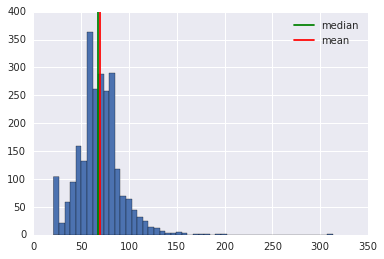

In [104]:
median = housing['Lot Frontage'].median()
mean = housing['Lot Frontage'].mean()
housing['Lot Frontage'].hist(bins = 50)
plt.axvline(median, c='g', label='median')
plt.axvline(mean, c='r', label='mean')
plt.legend();

In [105]:
print(median, mean)

68.0 69.2245901639


Not a huge difference, but the median looks like a *slightly* better measure of center.

In [106]:
housing['Lot Frontage'].fillna(housing['Lot Frontage'].median(), inplace=True)

The next group of columns missing data all relate to the garage, and this is probably a similar situation to our fireplace data where the missiving values are the result of there being no garage.

In [107]:
null_garages = ['Garage Cars', 'Garage Finish', 'Garage Qual', 'Garage Yr Blt',
                'Garage Cond', 'Garage Type', 'Garage Area']
#quick spot check
housing[housing['Garage Cars'] == 0][null_garages]

,Garage Cars,Garage Finish,Garage Qual,Garage Yr Blt,Garage Cond,Garage Type,Garage Area
27,0.0,NaN,NaN,NaN,NaN,NaN,0.0
119,0.0,NaN,NaN,NaN,NaN,NaN,0.0
125,0.0,NaN,NaN,NaN,NaN,NaN,0.0
129,0.0,NaN,NaN,NaN,NaN,NaN,0.0
130,0.0,NaN,NaN,NaN,NaN,NaN,0.0
170,0.0,NaN,NaN,NaN,NaN,NaN,0.0
171,0.0,NaN,NaN,NaN,NaN,NaN,0.0
186,0.0,NaN,NaN,NaN,NaN,NaN,0.0
203,0.0,NaN,NaN,NaN,NaN,NaN,0.0
206,0.0,NaN,NaN,NaN,NaN,NaN,0.0


In [108]:
def impute_with_none_0(df, cols):
    for col in cols:
        if df[col].dtype ==np.object:
            df[col].fillna('None', inplace=True)
        else:
            df[col].fillna(0, inplace=True)

In [109]:
impute_with_none_0(housing, null_garages)

In [110]:
nulls = (housing.isnull().sum() / housing.shape[0])
nulls[nulls>0].sort_values(ascending=False)

Bsmt Exposure     0.028328
BsmtFin Type 2    0.027645
BsmtFin Type 1    0.027304
Bsmt Cond         0.027304
Bsmt Qual         0.027304
Mas Vnr Area      0.007850
Mas Vnr Type      0.007850
Bsmt Half Bath    0.000683
Bsmt Full Bath    0.000683
Electrical        0.000341
Total Bsmt SF     0.000341
Bsmt Unf SF       0.000341
BsmtFin SF 2      0.000341
BsmtFin SF 1      0.000341
dtype: float64

Next we can take a look at all of the basement columns, hopefully they follow the same pattern as the fireplace and garage columns.

In [111]:
basement_nulls = ['Bsmt Exposure', 'BsmtFin Type 2', 'BsmtFin Type 1',
                  'Bsmt Cond', 'Bsmt Qual', 'Bsmt Half Bath',
                  'Bsmt Full Bath', 'Total Bsmt SF', 'Bsmt Unf SF', 
                  'BsmtFin SF 2', 'BsmtFin SF 1']

for col in basement_nulls:
    print(housing[col].isnull().sum())

83
81
80
80
80
2
2
1
1
1
1


In [112]:
housing[housing['Total Bsmt SF']==0][basement_nulls]

,Bsmt Exposure,BsmtFin Type 2,BsmtFin Type 1,Bsmt Cond,Bsmt Qual,Bsmt Half Bath,Bsmt Full Bath,Total Bsmt SF,Bsmt Unf SF,BsmtFin SF 2,BsmtFin SF 1
83,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
154,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
206,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
243,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
273,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
275,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
290,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
551,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
649,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
676,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


This explains 79 out of our 80 or 83 null values, what gives with the others?

`Exposure` and `Fin Type 2` both have rows where the column is null, but there is a listed SF for the basement. Let's take a look at them and then if reasonable impute the values using the most frequent values from the column.

In [113]:
housing[housing['Bsmt Exposure'].isnull() & housing['Total Bsmt SF']!=0][basement_nulls]

,Bsmt Exposure,BsmtFin Type 2,BsmtFin Type 1,Bsmt Cond,Bsmt Qual,Bsmt Half Bath,Bsmt Full Bath,Total Bsmt SF,Bsmt Unf SF,BsmtFin SF 2,BsmtFin SF 1
66,NaN,Unf,Unf,TA,Gd,0.0,0.0,1595.0,1595.0,0.0,0.0
1796,NaN,Unf,Unf,TA,Gd,0.0,0.0,725.0,725.0,0.0,0.0
2779,NaN,Unf,Unf,TA,Gd,0.0,0.0,936.0,936.0,0.0,0.0


In [114]:
bsmt_exp = housing[housing['Bsmt Exposure'].isnull() & housing['Total Bsmt SF']!=0][basement_nulls].index
for ind in bsmt_exp:
    housing.at[ind, 'Bsmt Exposure'] == housing['Bsmt Exposure'].mode()

In [115]:
housing[housing['BsmtFin Type 2'].isnull() & housing['Total Bsmt SF']!=0][basement_nulls]

,Bsmt Exposure,BsmtFin Type 2,BsmtFin Type 1,Bsmt Cond,Bsmt Qual,Bsmt Half Bath,Bsmt Full Bath,Total Bsmt SF,Bsmt Unf SF,BsmtFin SF 2,BsmtFin SF 1
444,No,NaN,GLQ,TA,Gd,0.0,1.0,3206.0,1603.0,479.0,1124.0


In [116]:
bsmtfin_2 = housing[housing['BsmtFin Type 2'].isnull() & housing['Total Bsmt SF']!=0][basement_nulls].index
for ind in bsmtfin_2:
    housing.at[ind, 'BsmtFin Type 2'] == housing['BsmtFin Type 2'].mode()

In [117]:
for col in ['BsmtFin Type 1', 'Bsmt Cond', 'Bsmt Qual']:
    print(housing[housing[col].isnull() & housing['Total Bsmt SF']!=0][basement_nulls])

Empty DataFrame
Columns: [Bsmt Exposure, BsmtFin Type 2, BsmtFin Type 1, Bsmt Cond, Bsmt Qual, Bsmt Half Bath, Bsmt Full Bath, Total Bsmt SF, Bsmt Unf SF, BsmtFin SF 2, BsmtFin SF 1]
Index: []
Empty DataFrame
Columns: [Bsmt Exposure, BsmtFin Type 2, BsmtFin Type 1, Bsmt Cond, Bsmt Qual, Bsmt Half Bath, Bsmt Full Bath, Total Bsmt SF, Bsmt Unf SF, BsmtFin SF 2, BsmtFin SF 1]
Index: []
Empty DataFrame
Columns: [Bsmt Exposure, BsmtFin Type 2, BsmtFin Type 1, Bsmt Cond, Bsmt Qual, Bsmt Half Bath, Bsmt Full Bath, Total Bsmt SF, Bsmt Unf SF, BsmtFin SF 2, BsmtFin SF 1]
Index: []


In [118]:
impute_with_none_0(housing, basement_nulls)

In [119]:
nulls = (housing.isnull().sum() / housing.shape[0])
nulls[nulls>0].sort_values(ascending=False)

Mas Vnr Area    0.007850
Mas Vnr Type    0.007850
Electrical      0.000341
dtype: float64

We are down to 2 masonry columns and the electrical system type.

Let's make sure all of our missing masonary values are the same rows, if so we can just impute the most common value or just 0/None for each missing value.

In [120]:
housing[(housing['Mas Vnr Area'].isnull())|
        (housing['Mas Vnr Type'].isnull())][['Mas Vnr Area', 'Mas Vnr Type']]

,Mas Vnr Area,Mas Vnr Type
55,NaN,NaN
484,NaN,NaN
517,NaN,NaN
538,NaN,NaN
867,NaN,NaN
1095,NaN,NaN
1119,NaN,NaN
1122,NaN,NaN
1127,NaN,NaN
1184,NaN,NaN


In [121]:
impute_with_none_0(housing, ['Mas Vnr Area', 'Mas Vnr Type'])

In [122]:
nulls = (housing.isnull().sum() / housing.shape[0])
nulls[nulls>0].sort_values(ascending=False)

Electrical    0.000341
dtype: float64

For the `Electrical` column we will just impute the most common value.

> Learned you can't use `df[col].mode()` the same way you use `.median()` or `.mean()` to impute values with `.fillna()`. See below for implementation.

In [123]:
elect_mode = housing['Electrical'].mode().values[0]
housing['Electrical'].fillna(elect_mode, inplace=True)

In [124]:
nulls = (housing.isnull().sum() / housing.shape[0])
nulls[nulls>0].sort_values(ascending=False)

Series([], dtype: float64)

There we go, we have dealt with all the null values in the dataset.

Let's create a few new features from values in the dataset.

In [125]:
years_sold = housing['Yr Sold'] - housing['Year Built']
years_until_remod = housing['Year Remod/Add'] - housing['Year Built']
years_since_remod = housing['Yr Sold'] - housing['Year Remod/Add']

In [126]:
print(years_sold[years_sold < 0])
print('')
print(years_until_remod[years_until_remod < 0])
print('')
print(years_since_remod[years_since_remod < 0])

2180   -1
dtype: int64

850   -1
dtype: int64

1702   -1
2180   -2
2181   -1
dtype: int64


Let's add these new feautres to our dataframe and drop the rows with negative values.

In [127]:
housing = housing.assign(years_sold=years_sold)
housing = housing.assign(years_until_remod=years_until_remod)
housing = housing.assign(years_since_remod=years_since_remod)

In [128]:
housing.drop([850, 1702, 2180, 2181], axis=0, inplace=True)

housing.drop(["Year Built", "Year Remod/Add", "Yr Sold"], axis = 1, inplace=True)

Let's move on to looking at feature selection, let's start by dropping low variance columns.

In [129]:
housing.drop(housing.var()[housing.var() < .25].index, 
             axis=1, inplace=True)

In [130]:
cat_cols = housing.select_dtypes(['object'])
for col in cat_cols:
    print(housing[col].value_counts() / housing[col].shape[0])
    print('')

RL         0.775461
RM         0.157895
FV         0.047505
RH         0.009228
C (all)    0.008544
A (agr)    0.000684
I (all)    0.000684
Name: MS Zoning, dtype: float64

Pave    0.995899
Grvl    0.004101
Name: Street, dtype: float64

Reg    0.635338
IR1    0.333219
IR2    0.025974
IR3    0.005468
Name: Lot Shape, dtype: float64

Lvl    0.899180
HLS    0.041012
Bnk    0.039303
Low    0.020506
Name: Land Contour, dtype: float64

AllPub    0.998975
NoSewr    0.000684
NoSeWa    0.000342
Name: Utilities, dtype: float64

Inside     0.730349
Corner     0.174299
CulDSac    0.061517
FR2        0.029050
FR3        0.004785
Name: Lot Config, dtype: float64

Gtl    0.951811
Mod    0.042720
Sev    0.005468
Name: Land Slope, dtype: float64

NAmes      0.151401
CollgCr    0.090909
OldTown    0.081681
Edwards    0.065619
Somerst    0.062201
NridgHt    0.056391
Gilbert    0.056391
Sawyer     0.051606
NWAmes     0.044771
SawyerW    0.042720
Mitchel    0.038961
BrkSide    0.036910
Crawfor    0.035202


Let's drop any categorical variables where the 85% of the response are in on category.

In [131]:
for col in cat_cols:
    cat_percent = housing[col].value_counts() / housing[col].shape[0]
    if cat_percent[cat_percent > 0.85].shape[0] > 0:
        housing.drop(col, axis=1, inplace=True)

Quick check;

In [132]:
cat_cols = housing.select_dtypes(['object'])

for col in cat_cols:
    print(housing[col].value_counts() / housing[col].shape[0])
    print('')

RL         0.775461
RM         0.157895
FV         0.047505
RH         0.009228
C (all)    0.008544
A (agr)    0.000684
I (all)    0.000684
Name: MS Zoning, dtype: float64

Reg    0.635338
IR1    0.333219
IR2    0.025974
IR3    0.005468
Name: Lot Shape, dtype: float64

Inside     0.730349
Corner     0.174299
CulDSac    0.061517
FR2        0.029050
FR3        0.004785
Name: Lot Config, dtype: float64

NAmes      0.151401
CollgCr    0.090909
OldTown    0.081681
Edwards    0.065619
Somerst    0.062201
NridgHt    0.056391
Gilbert    0.056391
Sawyer     0.051606
NWAmes     0.044771
SawyerW    0.042720
Mitchel    0.038961
BrkSide    0.036910
Crawfor    0.035202
IDOTRR     0.031784
Timber     0.024607
NoRidge    0.024265
StoneBr    0.017430
SWISU      0.016405
ClearCr    0.015038
MeadowV    0.012645
BrDale     0.010253
Blmngtn    0.009569
Veenker    0.008202
NPkVill    0.007861
Blueste    0.003418
Greens     0.002734
GrnHill    0.000684
Landmrk    0.000342
Name: Neighborhood, dtype: float64



Before moving on to create dummy variables, we are going to look at the correlation values for our numerical columns and see if any can be dropped.

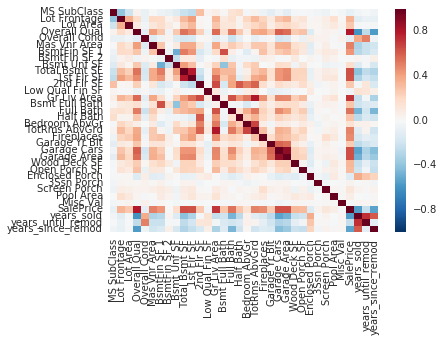

In [134]:
sns.heatmap(housing.corr());

In [151]:
housing_corr = housing.corr()
low_corr = housing_corr[(abs(housing_corr['SalePrice']) < 0.2)].index

In [152]:
housing.drop(low_corr, axis=1, inplace=True)

Do any of our columns contain a large number of categories?

In [153]:
for col in cat_cols:
    cat_percent = housing[col].value_counts() / housing[col].shape[0]
    print(cat_percent.shape[0])

7
4
5
28
5
8
6
16
17
5
4
6
6
5
7
5
5
6
7
4


A few do, let's take a look at what they are;

In [155]:
for col in cat_cols:
    cat_percent = housing[col].value_counts() / housing[col].shape[0]
    if cat_percent.shape[0] > 15:
        print(cat_percent.name)
        print('')

Neighborhood

Exterior 1st

Exterior 2nd



These should be pretty important in predicting a home's price, so we are going to leave them in when we create dummy variables.

First we turn our categorical columns that are currently of type `object` to type `category`. We can then use these values to create dummy variables and add them to our data set.

In [158]:
for col in cat_cols:
    housing[col] = housing[col].astype('category')

In [159]:
## Create dummy columns and add back to the dataframe!
housing = pd.concat([housing,
                     pd.get_dummies(housing.select_dtypes(include=['category']))],
                    axis=1)

In [180]:
housing.drop(housing.select_dtypes(['category']).columns, 
             axis=1, inplace = True)

In [181]:
housing.shape

(2926, 179)

In [182]:
features = housing.drop('SalePrice', axis = 1).columns

In [183]:
target = housing.SalePrice

In [184]:
kf = KFold(n_splits=3, shuffle=True)
lr = LinearRegression()

for train_index, test_index, in kf.split(housing):
    train = housing.iloc[train_index]
    test = housing.iloc[test_index]
    lr.fit(train[features], train.SalePrice)
    y_pred = lr.predict(test[features])
    mse = mean_squared_error(test.SalePrice, y_pred)
    rmse = np.sqrt(mse)
    print(rmse)

32497.8321831
24993.7903421
23782.2694034


Okay, so we could put this all into a script, so that if we work with an updated version of the same dataset, we can clean without having to do as much work.